## Calibration

In [8]:
import pyvisa
import time
import numpy as np
import urllib.request #to open URLs 
import functools as ft #complex operations
from bs4 import BeautifulSoup #aid in html reading
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
rm = pyvisa.ResourceManager()

keithley = rm.open_resource('TCPIP::10.10.15.130::INSTR') #connecting to device via LAN, it may change the IP address 
keithley.write(':SYST:REM')
keithley.write(':SOUR:FUNC CURR')  # Set the source function to current
keithley.write('SOUR:CURR:DEL:AUTO OFF')
keithley.write(':ROUT:TERM REAR')  # Set the output terminals to the rear panels
keithley.write(':OUTP ON')  # Turn on the output

10

In [3]:
current_list = [i * 10**-j for j in range(12, 3, -1) for i in range(1, 10)] #create a list that stores values

log_lin_voltages = []

url = 'http://10.10.15.22/cgi-bin/ope/allch.cgi'  #url of the yokogawa (truta) containing the voltage values

for current in current_list:
    keithley.write(f':SOUR:CURR {current}')
    time.sleep(1)

    values_for_average = []

    i=0
    while i<20:
        html = urllib.request.urlopen(url).read() #open url and read it
        soup = BeautifulSoup(html, 'html.parser') #parse the html

        tables = soup.find_all('table') #find the table in the html content
        table = tables[1] #there are 2 tables in the html content, we're interested in the second one (has the voltage values)

        td_elements = table.find_all('td', align='center') #this block of code is getting the values of the voltage by narrwoing down on
        voltage_values = []                                #some elements that their code lines have in common: 'td', 'center', 
        for td in td_elements:                             #'b', and not having 'width'. 
            b = td.find('b')                               
            if b:
                try:
                    value = float(b.text.strip())
                    if 'width' not in td.attrs:
                        voltage_values.append(value)
                except ValueError:
                    pass

        values_for_average.append(voltage_values[1])
        time.sleep(1)
        i+=1

    log_lin_voltages.append(sum(values_for_average)/len(values_for_average))    
    

Text(0.5, 1.0, 'Readings from "TRUTA" for different values of input current')

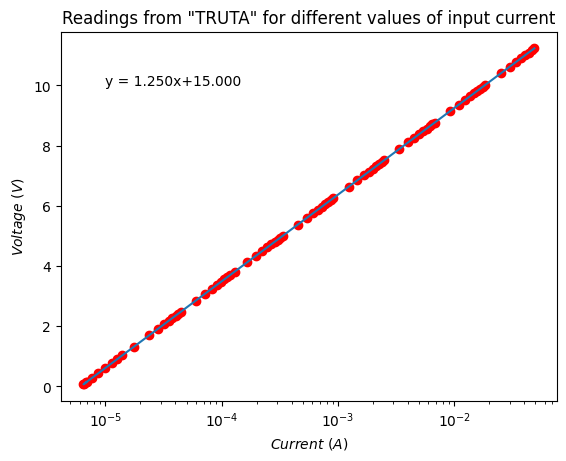

In [27]:
log_lin_current = []
for v in log_lin_voltages:
    i = np.exp((v-15)/1.25)
    log_lin_current.append(i)

x = np.log(log_lin_current)
y = log_lin_voltages
x = np.array(x).reshape(-1, 1)  # Reshape to 2D array (n_samples, n_features)

model = LinearRegression()
model.fit(x, y) #fit the model to the data
m = model.coef_[0] #slope coefficient 
b = model.intercept_ #interception in the y-axis
equation = f'y = {m:.3f}x+{b:.3f}'

plt.plot((log_lin_current), log_lin_voltages)
plt.scatter(log_lin_current, log_lin_voltages, color = 'r')
plt.annotate(equation, xy=(10e-5,10), xytext = (10e-6,10))
plt.xscale('log')
plt.xlabel('$Current \ (A)$')
plt.ylabel('$Voltage \ (V)$')
plt.title('Readings from "TRUTA" for different values of input current')

In [10]:
x = np.log(log_lin_current)
y = log_lin_voltages

x = np.array(x).reshape(-1, 1)  # Reshape to 2D array (n_samples, n_features)

model = LinearRegression()
model.fit(x, y) #fit the model to the data

slope = model.coef_[0] #slope coefficient 
intercept = model.intercept_ #interception in the y-axis

Equation of the regression line: y = 1.2500000000000007 * x + 15.000000000000005


In [5]:
keithley.write(':SOUR:CURR 5e-10')

18